# <p style="text-align: center;">Base Model for TP2 - Do you need more signs?</p>

### **1. Import the Required Libraries**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

### **2. Load the Image Training and Test Datasets**

#### **i. Get the Image Dataset Paths**

In [2]:
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'


### ii. Load Image Datasets 

We are going for the tiny version of the dataset!

In [3]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

Loading the training dataset. Via DataGenerators

In [4]:
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)


Split the Training Folder in Training / Validation

In [5]:
train_idx, valid_idx = train_test_split(
    range(len(traffic_signals_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=traffic_signals_dataset.targets
)

train_subset = Subset(traffic_signals_dataset, train_idx)
valid_subset = Subset(traffic_signals_dataset, valid_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

In [6]:
training_targets = traffic_signals_dataset.targets
t_targets = {k:0 for k in training_targets}
for t in training_targets:
    t_targets[t] += 1
print('Training class distribution:', t_targets)

Training class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


Loading the test dataset.

In [7]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [8]:
### subset version
#the_labels = {value for _, value in train_datagen.class_to_idx.items()}
labels = {value: key for key, value in traffic_signals_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in traffic_signals_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 22: 'Cenas', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 46: 'Unknown', 49: 'Unk1', 50: 'Fences', 54: 'Do Not Park', 55: 'Do', 57: 'Forbidden'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous curve to the right
4 : 39 - Dangerous curve to the left
5 : 44 - Go left or straight
6 : 46 - Unknown
7 : 49 - Unk1
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


### **2. Plotting Sample Training Images**

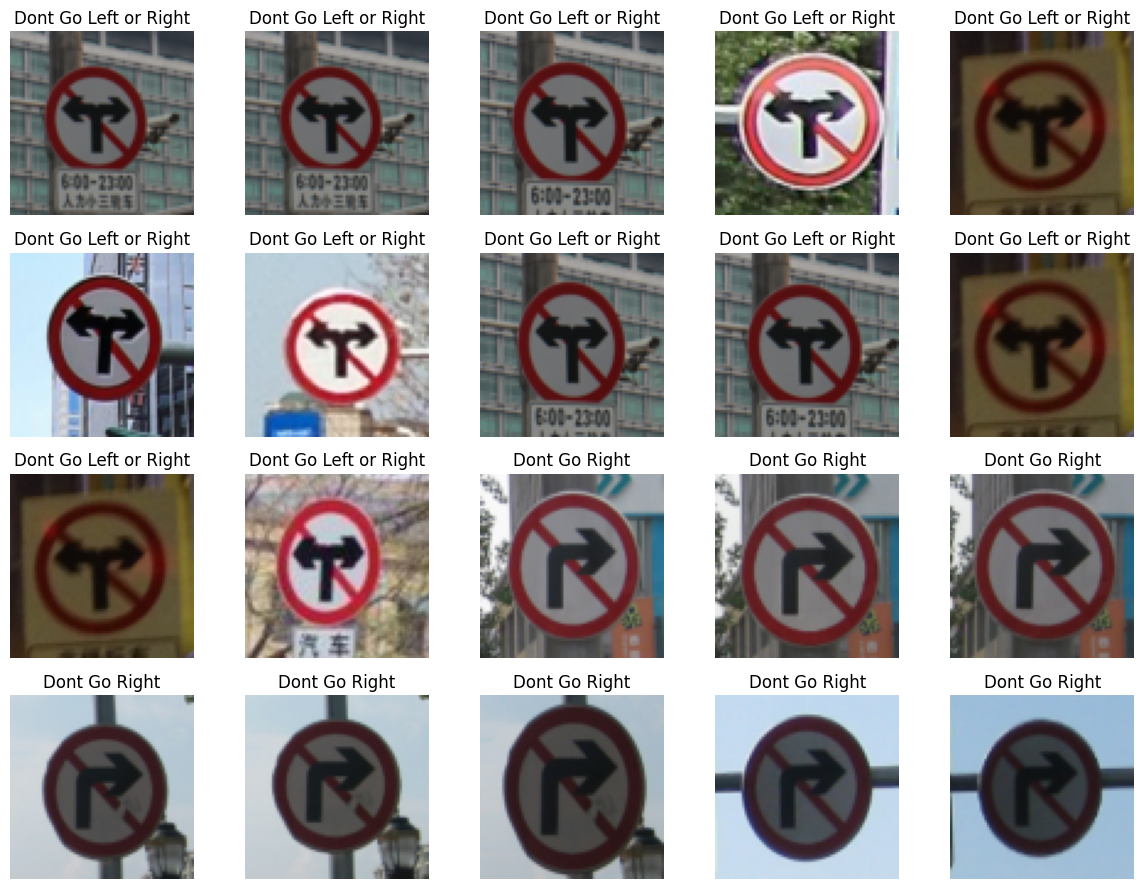

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(traffic_signals_dataset)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
#plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [10]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2


In [11]:
def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        print(f"Epoch {epoch+1} average loss: {cumulative_loss/len(train_dataset_loader)}")
    return model.to("cpu")

In [12]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

num_classes = len(labels)
print(num_classes)
print(device)
num_epochs = 15
model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


10
cpu


In [13]:
TRAIN_MODEL = False
if TRAIN_MODEL:
    ccnn = train_model(model, criterion, optimizer, train_dataset_loader, num_epochs, device)
    
else:
    ccnn = torch.load('baseline_model.pth')

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test_model(model, dataset_loader):
    y_real = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total,100 * correct / total))
    # Generate the confusion matrix
    cm = confusion_matrix(y_real, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

Accuracy of the model on the 28 test images: 78.57142857142857 %


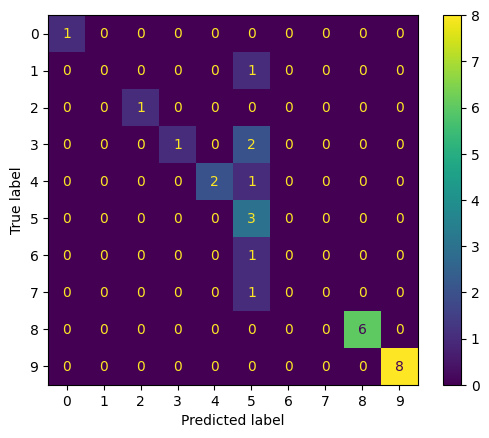

None


In [15]:
print(test_model(ccnn, validation_dataset_loader))